## imports

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

## load data

In [40]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz


Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [41]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [42]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

## one-hot encoding

In [43]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [44]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [45]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

## plot image function

In [46]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # show the true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

## Plot a few images to see if data is correct

In [47]:
# get the first set images from the test-set
images = data.test.images[0:9]
# get tht true classes for those images
cls_true = data.test.cls[0:9]
# plot the images and labels using the lot_images function
plot_images(images=images, cls_true=cls_true)

# Tensorflow Graph Construction
A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimized so as to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

## Placeholder variables

In [48]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables to be optimized

In [49]:
# initialize weight variables
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
# initialize bias variables
biases = tf.Variable(tf.zeros([num_classes]))

In [50]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
# dimension=1 means for each row to choose the argmax
y_pred_cls = tf.argmax(y_pred, axis=1)

## cost-function to be optimized

In [51]:
# cross_entropy can measure how well the model preform on each image
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
# reduce_mean takes the average of cross_entropy for every image, in other words cost
cost = tf.reduce_mean(cross_entropy)

## optimization method

In [52]:
# now we have a cost measure that must be optimized, that is our aim, we can create a optimizer using GD
# optimizer to minimize this cost
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## performance measures

In [53]:
# this is a vector of boolean whether the predicted class equals the true class of each image
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# tf.cast convert boolean into float32 so that False becomes 0 and True becomes one. Then we compute
# the mean of these correct numbers
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Tensorflow Run

## create tensorflow session
Once the graph has beed created, we have to create a Tensorflow session in order to execute the graph

In [54]:
session = tf.Session()

## initialize the varaibel
The variables for weights and biases must be initialized before we start optimizing them

In [55]:
session.run(tf.global_variables_initializer())

## helper-function to perform optimization iterations

In [56]:
# set up batch size
batch_size = 100

In [88]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # get a batch of training examples 
        # x_batch: a batch of images
        # y_true_batch = true labels for those images
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # put batch into a dict with the proper names for placeholder variables in the Tensorflow graph
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        # run the optimizer using this batch of training data
        # Tensorflow assigns the placeholder variables in feed_dict_train
        session.run(optimizer, feed_dict=feed_dict_train)

## Helper-functions to show the performance
Dict with test-set data to be used in the Tensorflow graph. Note, we must use the correct names for the placeholder variables in the Tensorflow graph.

In [58]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [59]:
# functions for printing the classification accuracy on the test-set
def print_accuracy():
    # use tensorflow to compute the accuracy
    # we need to run the session if there is placeholder variables
    # using the optimized weights and biased from the model after training
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # print the accuracy
    print("Accuracy on the test-set: {0:.1%}".format(acc))

function for plotting the confusing function matrix using scikit_learn

In [106]:
def print_confusion_matrix():
    # get the true classifications for the test-set
    cls_true = data.test.cls
    
    # get the predicted classifications for the test-set using optimized weights and biases by feeding
    # the test data-set
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # print the confusion matrix
    print cm
    
    # plot the confusion matrix as an image
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # make various adjustments to the plot
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [93]:
# function for plotting examples of images from the test-set that have been mis-classified
def plot_example_errors():
    # use the Tensorflow to get a list of boolean values whether each test-image has been
    # correctly classified 
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    
    # negative the boolean array
    incorrect = (correct == False) #????????
    
    # get the images from the test-set that have been incorrectly classified
    images = data.test.images[incorrect]
    
    # get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    # get the true classes for those images 
    cls_true = data.test.cls[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])
    plt.show()

## Helper-function to plot the model weights

In [95]:
# function for plotting the weights of from the Tensorflow variable
def plot_weights():
    # get the value of weights from the Tensorflow variable
    # Since there are no placeholder for computing the weights(Tensorflow variable) so that
    # we don't need to feed dict for session.run
    w = session.run(weights)
    
    # get the lowest and highest weight values in order to use the color density correctly
    w_min = np.min(w)
    w_max = np.max(w)
    
    # create figure with 3x4 sub-plots, where the last 2 sub-plots are unused
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # only use the weights for the first 9 sub-plots
        if i < 10:
            # get the weights for the i'th digit and reshape it
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)
            
            # set the label for sub-plot
            ax.set_xlabel("Weights: {0}".format(i))
            
            # plot the image
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        # remove ticks from each sub-plot
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

## performance before any optimization

In [63]:
print_accuracy()

Accuracy on the test-set: 9.8%


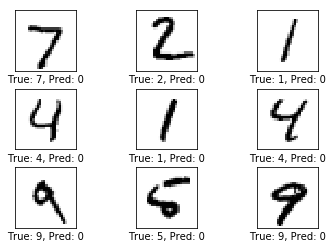

In [83]:
plot_example_errors()
plt.show()

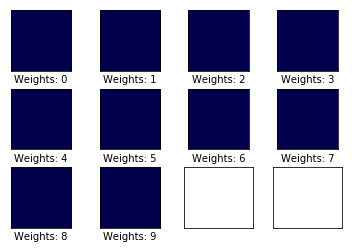

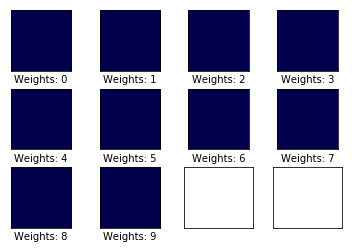

In [85]:
plot_weights()
plt.show()

# Performance after 10 optimization iterations

In [89]:
# we have already perform 1 iteration
optimize(num_iterations=9)

In [90]:
print_accuracy()

Accuracy on the test-set: 68.6%


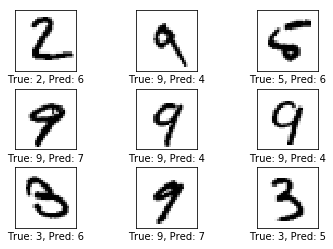

In [94]:
plot_example_errors()

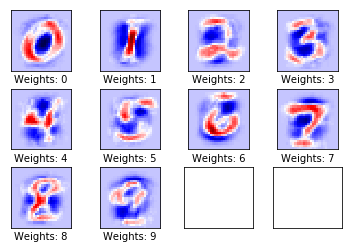

In [96]:
plot_weights()

# Performance after 1000 optimization iterations

In [97]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [98]:
print_accuracy()

Accuracy on the test-set: 91.7%


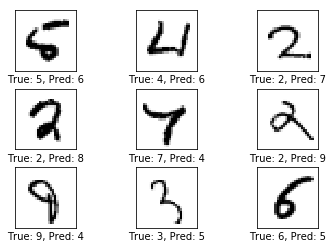

In [99]:
plot_example_errors()

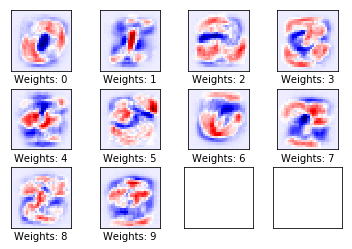

In [100]:
plot_weights()

[[ 960    0    0    1    0    5   10    1    3    0]
 [   0 1101    2    2    0    2    4    2   22    0]
 [  12   13  868   17   14    4   13   14   65   12]
 [   3    1    7  911    1   32    3    8   26   18]
 [   1    1    2    1  898    0   11    2    8   58]
 [  10    3    0   25   10  774   17    4   38   11]
 [  11    3    3    2   10   16  905    2    6    0]
 [   2    9   17    7    6    1    0  924    3   59]
 [   7    4    3   14    9   20   10    6  882   19]
 [  10    5    1    7   16    5    1    7   11  946]]


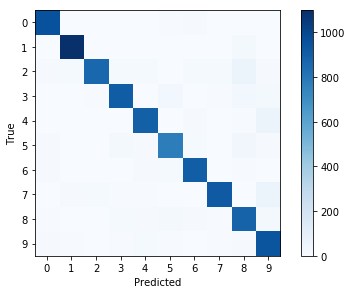

In [107]:
print_confusion_matrix()